# Setup

### Dependencies

In [ ]:
# !pip install transformers
# !pip install accelerate
# !pip install pandas
# !pip install gdown
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install wordcloud
# !pip install spacy
# !pip install scikit-learn
# !pip install textblob
!pip install dython

### Load libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import dython
import ast
import re

import nltk
import spacy
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !python -m spacy download en

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Download data


In [ ]:
# Download data
!gdown --folder 'https://drive.google.com/drive/folders/1-6zWtQdrVlxNqO_-_9avDnWaMC2lxg0S'

Retrieving folder list
Processing file 1KkQWp6-s7m3fkOVUHwpYvUq_-yumeQsz details-all.csv
Processing file 1qvsotI-hdXQTWzrzXDbPVKqCXXFzo8Ke googleHotel_wholeReview.xlsx
Processing file 1jAqdcC3ZkyByOBw61cy7o0Z5b_nxflnU hotels-london-1704121760126.csv
Processing file 1HzgmINSRzcyr5n3Es4Nuu7lGmmzcOuUi reviews-1703178005771.csv
Processing file 1w9GyqNapinl548GCmjRr7xF6d4jbYu3Z reviews-all.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1KkQWp6-s7m3fkOVUHwpYvUq_-yumeQsz
To: /content/data/details-all.csv
100% 105k/105k [00:00<00:00, 82.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qvsotI-hdXQTWzrzXDbPVKqCXXFzo8Ke
To: /content/data/googleHotel_wholeReview.xlsx
100% 34.6k/34.6k [00:00<00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jAqdcC3ZkyByOBw61cy7o0Z5b_nxflnU
To: /content/data/hotels-london-1704121760126.csv
100% 13.9k/13.9k [00:00<00:00, 40.8MB/

In [ ]:
# Create plot's output folder
if not os.path.exists('plots'):
    os.mkdir('plots')

In [ ]:
!ls

data  plots  sample_data


# Data overview and preprocessing

## 1. Read data

In [ ]:
!ls data

details-all.csv		      hotels-london-1704121760126.csv  reviews-all.csv
googleHotel_wholeReview.xlsx  reviews-1703178005771.csv


### Reviews data

**Load data**

In [ ]:
data_reviews = pd.read_csv(
    'data/reviews-all.csv',
    header=0
)

data_reviews.head()

,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions
0,Premier Inn Birmingham South (Longbridge Stati...,I am using the hotel as a base as my partner i...,5.0,2023-11-03,NaN,Couple
1,Premier Inn Birmingham South (Longbridge Stati...,We regularly use this premier inn as my in law...,5.0,2023-10-04,Vacation,Family
2,Premier Inn Birmingham South (Longbridge Stati...,"Only stayed for less than 24 hours, but the pe...",5.0,2023-12-12,NaN,NaN
3,Premier Inn Birmingham South (Longbridge Stati...,"I have stayed at a dozen of premier inns, this...",5.0,2023-12-12,NaN,Couple
4,Premier Inn Birmingham South (Longbridge Stati...,Very basic budget hotel. Booked as local to an...,2.0,2023-12-19,NaN,NaN


**Data shape**

In [ ]:
print('shape:', data_reviews.shape)
print('columns:', data_reviews.columns.values)

shape: (20508, 6)
columns: ['hotel_name' 'review_text' 'rating' 'review_timestamp' 'trip_type'
 'trip_companions']


### Hotels data

**Load data**

In [ ]:
data_hotels = pd.read_csv(
    'data/details-all.csv',
    header=0
).drop('amenities', axis=1)

data_hotels.head()

,name,address,images_count,popular_amenities,source
0,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
1,Premier Inn Birmingham City Centre Bridge Stre...,"20 Bridge St, Birmingham B1 2JR, United Kingdom",52,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
2,Premier Inn Birmingham City Centre (Exchange S...,"6, Exchange Square, The Priory Queensway, Birm...",25,"['Wi-Fi', 'Restaurant']",Google
3,Travelodge Birmingham Central Bull Ring,"Upper Dean St, Birmingham B5 4SG, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Restaurant']",Google
4,Travelodge Birmingham Central,"230 Broad St, Birmingham B15 1AY, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Pet-friendly']",Google


**Data shape**

In [ ]:
print('shape:', data_hotels.shape)
print('columns:', data_hotels.columns.values)

shape: (200, 5)
columns: ['name' 'address' 'images_count' 'popular_amenities' 'source']


### Merge data

Check if the set of hotels of these 2 table are the same before joining them.

In [ ]:
set_hotels_reviews_data = set(data_reviews['hotel_name'])
set_hotels_hotels_data = set(data_hotels['name'])

set_hotels_reviews_data == set_hotels_hotels_data

True

Now they are proved to be the same, we can join them into 1 table

In [ ]:
data = pd.merge(data_reviews, data_hotels, how='inner', left_on='hotel_name', right_on='name')

print('Shape:', data.shape)
data.head()

Shape: (20508, 11)


,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions,name,address,images_count,popular_amenities,source
0,Premier Inn Birmingham South (Longbridge Stati...,I am using the hotel as a base as my partner i...,5.0,2023-11-03,NaN,Couple,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
1,Premier Inn Birmingham South (Longbridge Stati...,We regularly use this premier inn as my in law...,5.0,2023-10-04,Vacation,Family,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
2,Premier Inn Birmingham South (Longbridge Stati...,"Only stayed for less than 24 hours, but the pe...",5.0,2023-12-12,NaN,NaN,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
3,Premier Inn Birmingham South (Longbridge Stati...,"I have stayed at a dozen of premier inns, this...",5.0,2023-12-12,NaN,Couple,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
4,Premier Inn Birmingham South (Longbridge Stati...,Very basic budget hotel. Booked as local to an...,2.0,2023-12-19,NaN,NaN,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google


## 2. Descriptive statistics

**Numerical Summary**

In [ ]:
data.describe()

,rating,images_count
count,20508.000000,20508.000000
mean,3.845329,40.586942
std,1.380386,49.895527
min,1.000000,0.000000
25%,3.000000,16.000000
50%,4.000000,26.000000
75%,5.000000,44.000000
max,5.000000,344.000000


**Categorical Summary**

In [ ]:
data.describe(include='object')

,hotel_name,review_text,review_timestamp,trip_type,trip_companions,name,address,popular_amenities,source
count,20508,20474,20508,10288,11175,20508,20508,20508,20508
unique,200,20466,55,2,4,200,200,51,1
top,Premier Inn Birmingham South (Longbridge Stati...,"Great prices, even at weekends, with very easy...",2023-01-02,Vacation,Couple,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom","['Wi-Fi', 'Air conditioning', 'Breakfast', 'Re...",Google
freq,109,2,2979,7538,3917,109,109,5638,20508


In [ ]:
print('trip_type:', data.trip_type.unique())
print('trip_companions:', data.trip_companions.unique())

trip_type: [nan 'Vacation' 'Business']
trip_companions: ['Couple' 'Family' nan 'Friends' 'Solo']


## 3. Data cleaning and preprocessing

### Missing values

In [ ]:
# Check for missing values
null_count = data.isnull().sum()
null_pct = (null_count / data.shape[0]) * 100

pd.DataFrame([null_count, null_pct],
             index=['Null count', 'Null percentages'])

,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions,name,address,images_count,popular_amenities,source
Null count,0.0,34.000000,0.0,0.0,10220.000000,9333.00000,0.0,0.0,0.0,0.0,0.0
Null percentages,0.0,0.165789,0.0,0.0,49.834211,45.50907,0.0,0.0,0.0,0.0,0.0


The columns `trip_type` and `trip_companions` have a significant number of missing values (`10220` and `9333` respectively), we will try to fill them with `unknown` values.

In [ ]:
data.fillna({
    'trip_type': 'unknown',
    'trip_companions': 'unknown'
}, inplace=True)

The column `review_text` also has some empty values (`34` empty strings). Since the number of empty `review_text` is small, we can drop them.

In [ ]:
data = data.dropna(subset=['review_text'])
data.reset_index(drop=True, inplace=True)
data.shape

(20474, 11)

### Duplicate values

In [ ]:
data.duplicated().sum()

0

### Data types

In [ ]:
# Check current data types of all columns
data.dtypes

hotel_name            object
review_text           object
rating               float64
review_timestamp      object
trip_type             object
trip_companions       object
name                  object
address               object
images_count           int64
popular_amenities     object
source                object
dtype: object

In [ ]:
# Convert `review_timestamp` column to datetime format for easier time-based analysis
data.review_timestamp = pd.to_datetime(data.review_timestamp, format='%Y-%m-%d')

In [ ]:
# Show processed data types
data.dtypes

hotel_name                   object
review_text                  object
rating                      float64
review_timestamp     datetime64[ns]
trip_type                    object
trip_companions              object
name                         object
address                      object
images_count                  int64
popular_amenities            object
source                       object
dtype: object

### One-hot encoding

Convert `trip_type` and `trip_companions`to one-hot encoding

In [ ]:
# One-hot encode trip_type
trip_type_dummies = pd.get_dummies(data['trip_type'], prefix='type')
# data.drop('trip_type', axis=1, inplace=True); data.reset_index(drop=True, inplace=True)
data = pd.concat([data, trip_type_dummies], axis=1)

# One-hot encode trip_companions
trip_companions_dummies = pd.get_dummies(data['trip_companions'], prefix='companions')
# data.drop('trip_companions', axis=1, inplace=True); data.reset_index(drop=True, inplace=True)
data = pd.concat([data, trip_companions_dummies], axis=1)

Convert `popular_amenities` to one-hot encoding

In [ ]:
categories_lists = data['popular_amenities'].apply(ast.literal_eval)
amenities_df = pd.get_dummies(categories_lists.apply(pd.Series).stack(), prefix='amenity').sum(level=0)

amenities_df = amenities_df.groupby(amenities_df.columns, axis=1).sum()

# concat the original data frame with the new `amenities` columns
data = pd.concat([data, amenities_df], axis=1)
# data.drop('popular_amenities', axis=1, inplace=True); data.reset_index(drop=True, inplace=True)

In [ ]:
# Fill NaN values with 0 in amenity columns
amenity_columns = data.filter(regex='^amenity_', axis=1)
data[amenity_columns.columns] = amenity_columns.fillna(0)

In [ ]:
print('popular amenities:', amenities_df.columns.values)

popular amenities: ['amenity_Air conditioning' 'amenity_Airport shuttle' 'amenity_Breakfast'
 'amenity_Fitness center' 'amenity_Hot tub' 'amenity_Kitchen in rooms'
 'amenity_Parking' 'amenity_Pet-friendly' 'amenity_Pool'
 'amenity_Restaurant' 'amenity_Spa' 'amenity_Wi-Fi']


In [ ]:
print('Shape:', data.shape)
data.head()

Shape: (20474, 31)


,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions,name,address,images_count,popular_amenities,...,amenity_Breakfast,amenity_Fitness center,amenity_Hot tub,amenity_Kitchen in rooms,amenity_Parking,amenity_Pet-friendly,amenity_Pool,amenity_Restaurant,amenity_Spa,amenity_Wi-Fi
0,Premier Inn Birmingham South (Longbridge Stati...,I am using the hotel as a base as my partner i...,5.0,2023-11-03,unknown,Couple,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,Premier Inn Birmingham South (Longbridge Stati...,We regularly use this premier inn as my in law...,5.0,2023-10-04,Vacation,Family,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,Premier Inn Birmingham South (Longbridge Stati...,"Only stayed for less than 24 hours, but the pe...",5.0,2023-12-12,unknown,unknown,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Premier Inn Birmingham South (Longbridge Stati...,"I have stayed at a dozen of premier inns, this...",5.0,2023-12-12,unknown,Couple,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,Premier Inn Birmingham South (Longbridge Stati...,Very basic budget hotel. Booked as local to an...,2.0,2023-12-19,unknown,unknown,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Cleaning text data

In [ ]:
class Cleaner:

    def __init__(self):
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.list_stopwords = set(nltk.corpus.stopwords.words('english'))
        self.nlp = spacy.load("en_core_web_sm")

    def clean(self, data, text_field='review_text'):
        self.data = data
        self.text_field = text_field
        self.cleaned_field = text_field + '_cleaned'

        self.data[self.cleaned_field] = self.data[self.text_field]

        # Cleaning text
        for cleanup_method in self.iterate():
            cleanup_method()

        # Preprocess text tokens
        self.data[self.cleaned_field] = self.data[self.cleaned_field].apply(self.preprocessing)

    def iterate(self):
        for cleanup_method in [self.remove_usernames,
                               self.clean_text,
                               self.lower_text,
                               self.remove_empty]:
            yield cleanup_method

    def remove_usernames(self):
        """ remove all user tags that start with @ """
        self.remove_by_regex(re.compile(r"@[^\s]+[\s]?"))

    def clean_text(self):
        """ remove digits and other characters except A-Z a-z and white spaces, replaced by 1 white space """
        self.remove_by_regex(re.compile(r"[^A-Za-z]+"), ' ')

    def lower_text(self):
        """ Format all letters into lowercase """
        self.data[self.cleaned_field] = self.data[self.cleaned_field].str.lower()

    def remove_empty(self):
        self.data.dropna(subset=[self.cleaned_field])
        self.data.reset_index(inplace=True)

    def preprocessing(self, text):
        """ Tokenize the text string to remove stopwords and apply lemmatization """

        list_tokens = self.tokenize(text)
        list_tokens = self.remove_stopwords(list_tokens)
        list_tokens = self.lemmatize(list_tokens)
        result_text = ' '.join(list_tokens)
        if len(list_tokens) >= 512:
            result_text = self.summarize(result_text)

        return result_text

    def tokenize(self, text, return_as_str=False):
        """ apply word tokenizer of nltk.tokenize to return a list of word tokens in English """

        res = nltk.tokenize.word_tokenize(text)
        if return_as_str:
            res = ' '.join(res)
        return res

    def remove_stopwords(self, list_tokens):
        """ remove all stopwords in the list of stopwords in English from nltk """
        text_non_stopwords = [w for w in list_tokens if w not in self.list_stopwords]
        return text_non_stopwords

    def lemmatize(self, list_tokens):
        """
            Converts word tokens in the list_token to their meaningful base forms, which is called Lemma.
            For example: 'tokens' -> 'token'.
            Lemmatization is computationally expensive since it involves look-up tables and what not.
        """

        list_base_tokens = [self.lemmatizer.lemmatize(w) for w in list_tokens]
        return list_base_tokens

    def summarize(self, text, n=20, max_tokens=512):
        """
            Summarize a text into n sentences.
            This function is not used in this notebook.
        """
        doc = self.nlp(text)
        sentences = [sent.text for sent in doc.sents]
        sentences.sort(key=lambda x: len(x.split()), reverse=True)
        while True:
            summary = ' '.join(sentences[:n])
            if len(self.tokenize(summary)) <= max_tokens:
                break
            else:
                n -= 1
        return summary

    def remove_by_regex(self, regexp, replaced_by=''):
        self.data.loc[:, self.cleaned_field].replace(regexp, replaced_by, inplace=True)

In [ ]:
cleaner = Cleaner()
cleaner.clean(data)

data[[cleaner.text_field, cleaner.cleaned_field]]

,review_text,review_text_cleaned
0,I am using the hotel as a base as my partner i...,using hotel base partner royal orthopedic hosp...
1,We regularly use this premier inn as my in law...,regularly use premier inn law live nearby rece...
2,"Only stayed for less than 24 hours, but the pe...",stayed le hour person reception welcoming room...
3,"I have stayed at a dozen of premier inns, this...",stayed dozen premier inn top list best stay ex...
4,Very basic budget hotel. Booked as local to an...,basic budget hotel booked local event attendin...
...,...,...
20469,Very nice and comfortable place. Was on a busi...,nice comfortable place business trip location ...
20470,"Staffs were very friendly and helpful, breakfa...",staff friendly helpful breakfast really good r...
20471,I'm totally disappointed with this Premier Inn...,totally disappointed premier inn towel pillow ...
20472,This is an aging hotel. No AC in the room so w...,aging hotel ac room hot sleep traffic could he...


# EDA

## 1. Univariate analysis

### 1.1. Distribution of Ratings

In [ ]:
data.value_counts('rating').sort_index()

rating
1.0    2356
2.0    1576
3.0    2499
4.0    4520
5.0    9523
dtype: int64

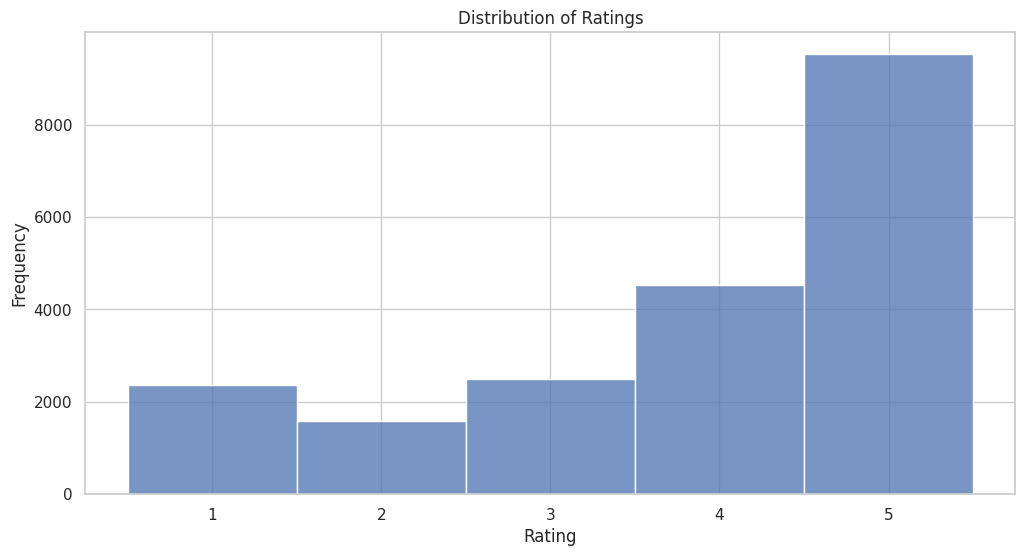

In [ ]:
# Setting the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution of ratings
plt.figure(figsize=(12, 6))
sns.histplot(data['rating'], kde=False, discrete=True)
plt.xticks(range(1, 6))
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('plots/1.1. Distribution of Ratings.png', bbox_inches='tight')
plt.show()

### 1.2. Trip companions

In [ ]:
data['trip_companions'].value_counts()

unknown    9307
Couple     3915
Family     3078
Solo       2528
Friends    1646
Name: trip_companions, dtype: int64

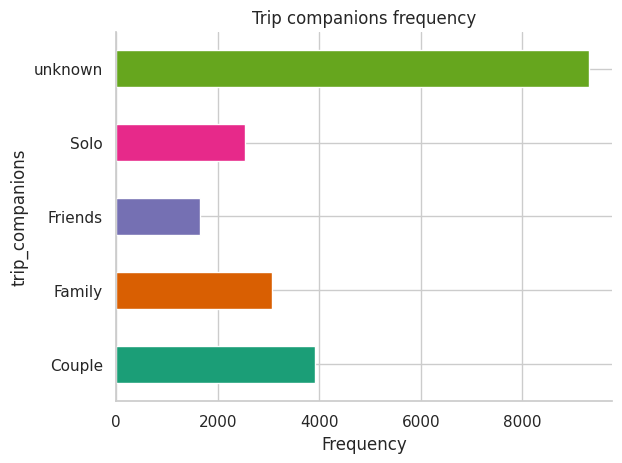

In [ ]:
data.groupby('trip_companions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Frequency')
plt.title('Trip companions frequency')
plt.savefig('plots/1.2. Trip companions frequency.png', bbox_inches='tight')
plt.show()

## 2. Bivariate analysis

### 2.1. Trip companions vs Ratings

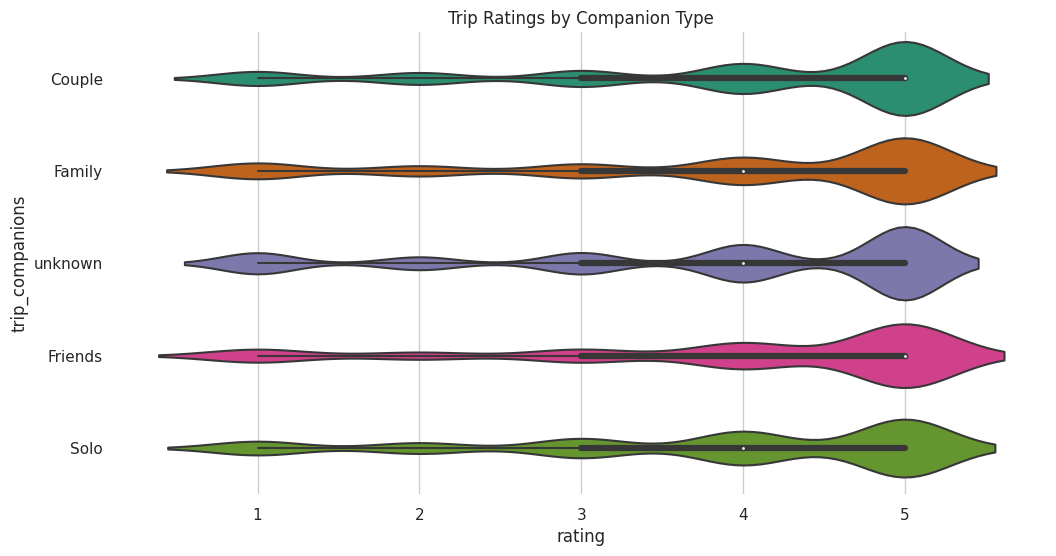

In [ ]:
figsize = (12, 1.2 * len(data['trip_companions'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='rating', y='trip_companions', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Trip Ratings by Companion Type')
plt.savefig('plots/2.1. Trip Ratings by Companion Type.png', bbox_inches='tight')
plt.show()

### 2.2. Review count over time

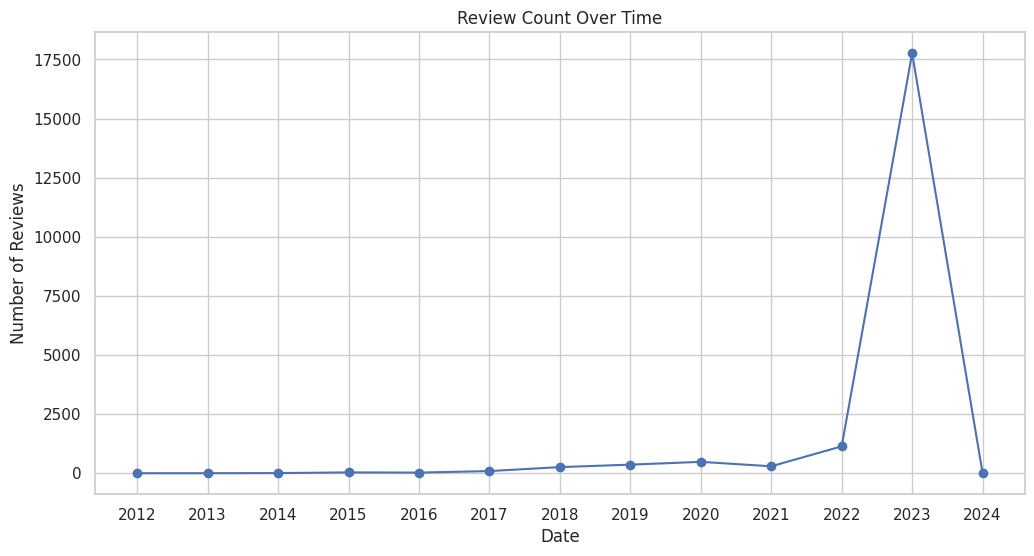

In [ ]:
# Review count over time
plt.figure(figsize=(12, 6))
data['review_timestamp'].dt.year.value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Review Count Over Time')
plt.xticks(list(set(data['review_timestamp'].dt.year)), rotation=0, ha='center')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.savefig('plots/2.2. Review count over time.png', bbox_inches='tight')
plt.show()

## 3. Multivariate analysis

### Helper functions

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = dython.nominal.conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


def compute_cat_corr(cat_data, num_data=None, corr_type='cramers_v'):
    if corr_type == 'cramers_v':
        corr_func = cramers_v
    elif corr_type == 'theils_u':
        corr_func = theils_u
    elif corr_type == 'mixed':
        corr_func = correlation_ratio

    if num_data is None:
        num_data = cat_data

    correlation_matrix = pd.DataFrame(index=cat_data.columns, columns=num_data.columns)
    for col_cat in cat_data.columns:
        for col_num in num_data.columns:
            correlation_matrix.loc[col_cat, col_num] = corr_func(cat_data[col_cat], num_data[col_num])
    correlation_matrix = correlation_matrix.apply(pd.to_numeric)

    return correlation_matrix

### 3.1. Categorical Correlation

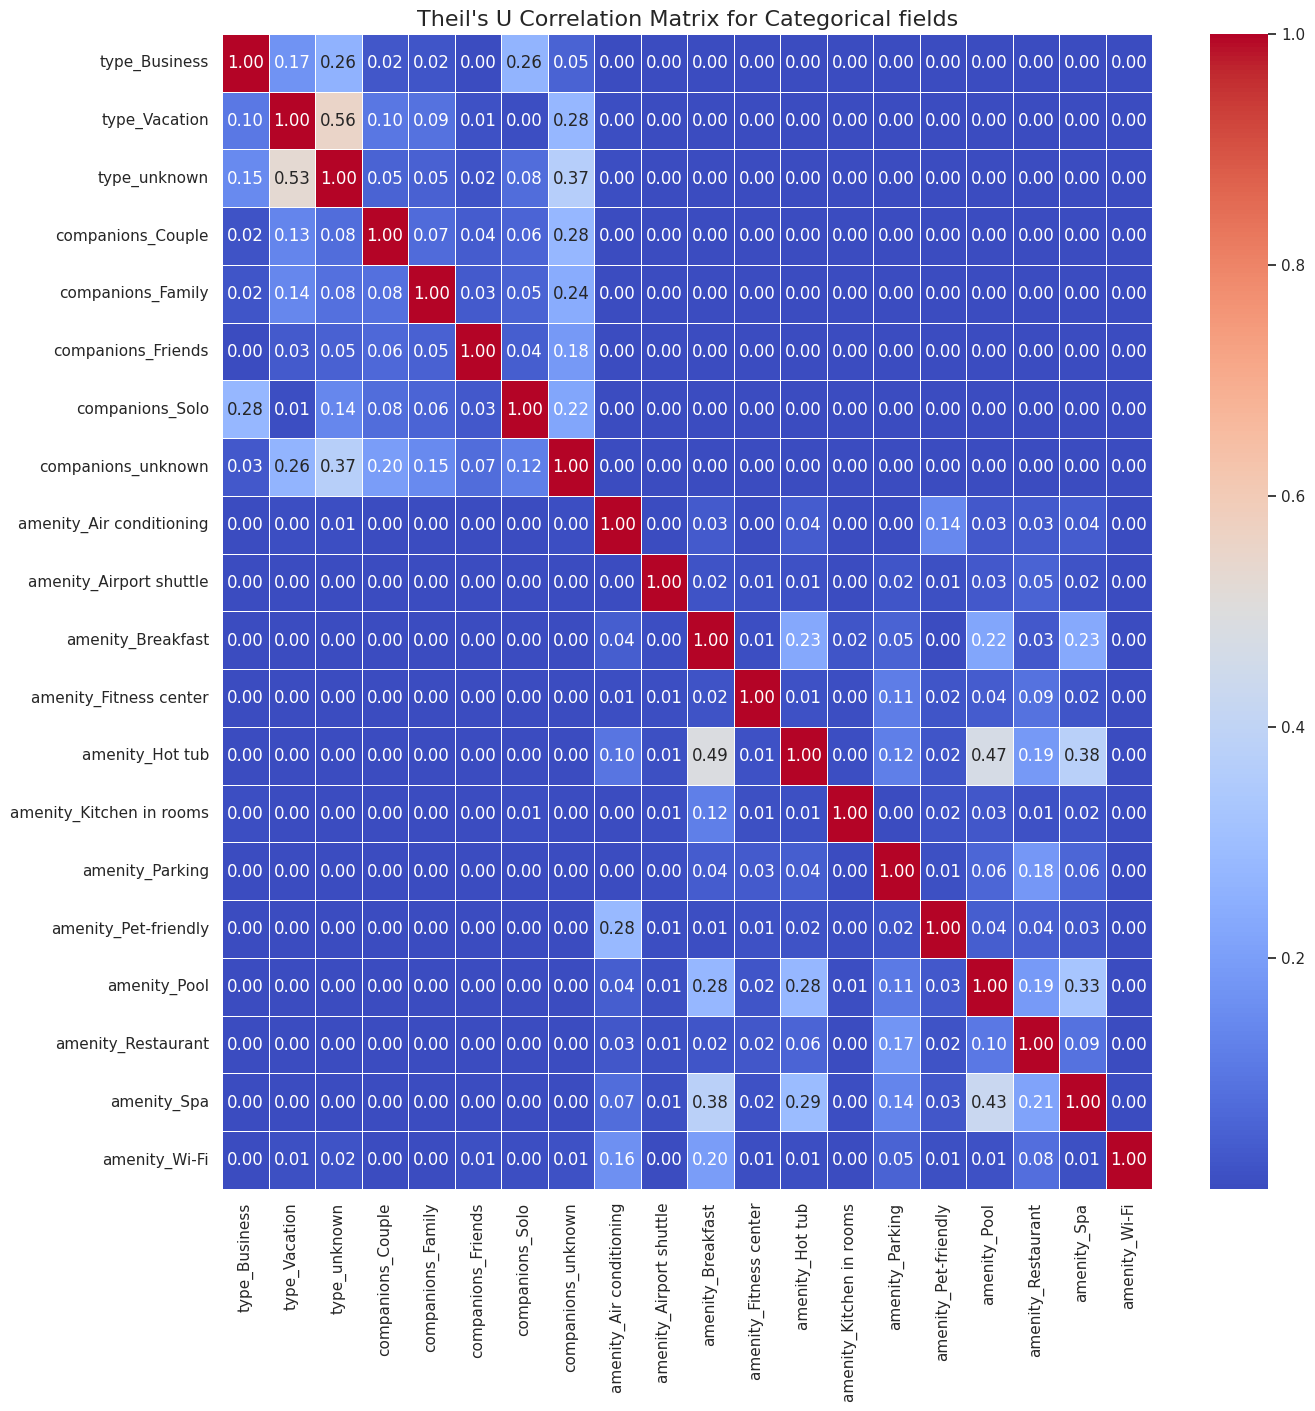

In [ ]:
cat_data = data.filter(regex='^type_|^amenity_|^companions_', axis=1)
correlation_matrix = compute_cat_corr(cat_data, corr_type='theils_u')

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Theil's U Correlation Matrix for Categorical features", fontsize=16)
plt.savefig('plots/3.1. Theil\'s U Correlation Matrix for Categorical features.png', bbox_inches='tight')
plt.show()


### 3.2. Mixed correlation

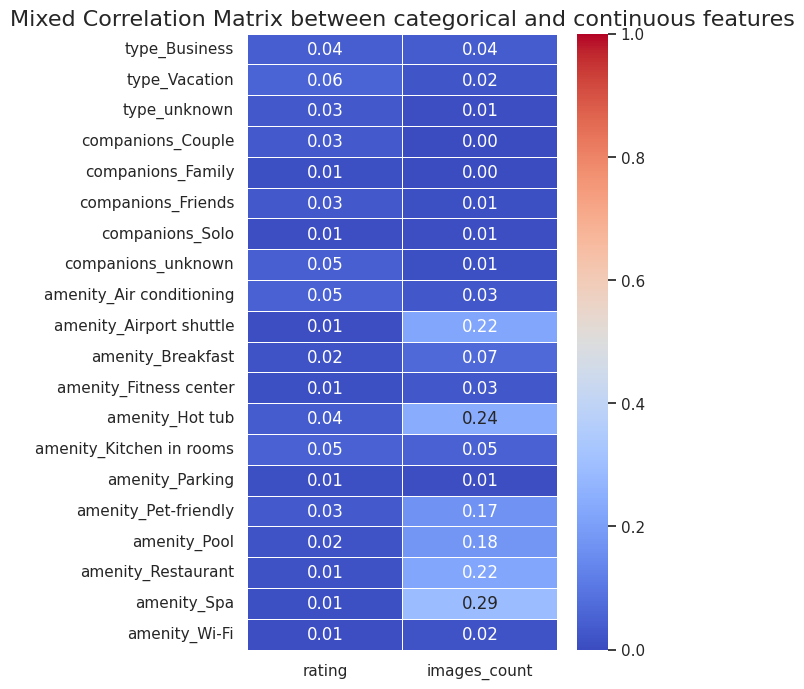

In [ ]:
num_data = data.loc[:, ['rating', 'images_count']]
correlation_matrix = compute_cat_corr(cat_data, num_data, corr_type='mixed')

plt.figure(figsize=(5, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=0, vmax=1)
plt.title("Mixed Correlation Matrix between categorical and continuous features", fontsize=16)
plt.savefig('plots/3.2. Mixed Correlation Matrix between categorical and continuous features.png', bbox_inches='tight')
plt.show()


## 4. Text Analysis

### 4.1. Text length

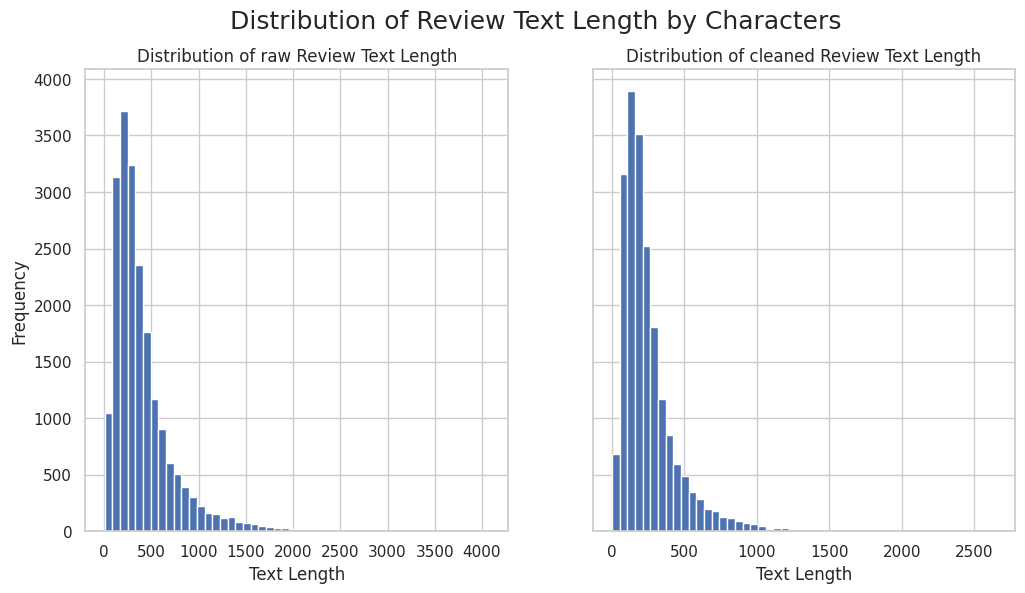

In [ ]:
# Generate a histogram of the text lengths
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle('Distribution of Review Text Length by Characters', fontsize=18)

axes[0].hist(data['review_text'].str.len(), bins=50)
axes[0].set_title('Distribution of raw Review Text Length')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(data['review_text_cleaned'].str.len(), bins=50)
axes[1].set_title('Distribution of cleaned Review Text Length')
axes[1].set_xlabel('Text Length')

plt.savefig('plots/4.1a. Distribution of Review Text Length by Characters.png', bbox_inches='tight')
plt.show()

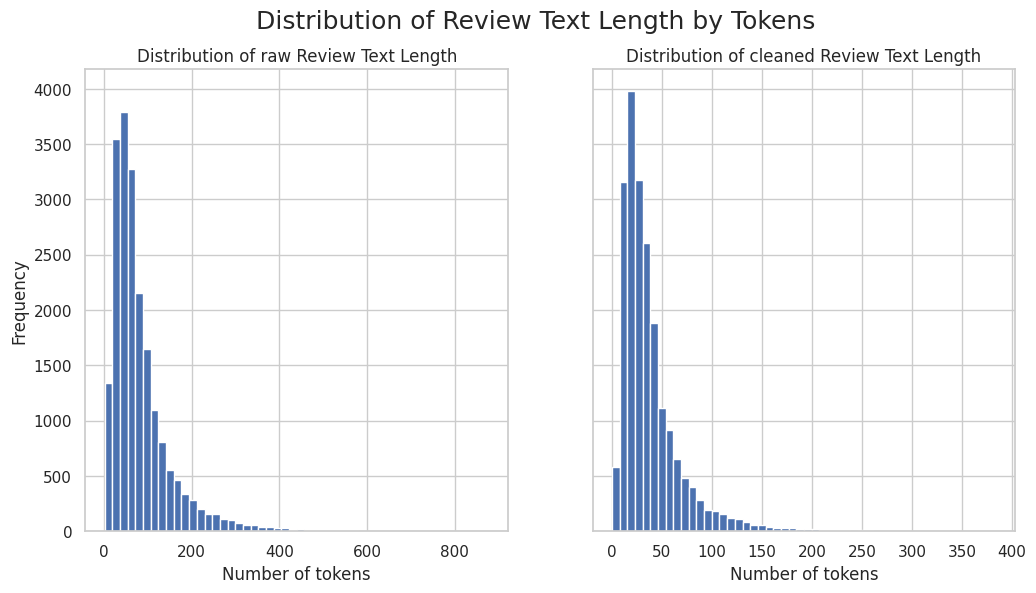

In [ ]:
# Generate a histogram of the number of tokens
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle('Distribution of Review Text Length by Tokens', fontsize=18)

axes[0].hist(data['review_text'].apply(cleaner.tokenize).apply(len), bins=50)
axes[0].set_title('Distribution of raw Review Text Length')
axes[0].set_xlabel('Number of tokens')
axes[0].set_ylabel('Frequency')

axes[1].hist(data['review_text_cleaned'].apply(cleaner.tokenize).apply(len), bins=50)
axes[1].set_title('Distribution of cleaned Review Text Length')
axes[1].set_xlabel('Number of tokens')

plt.savefig('plots/4.1b. Distribution of Review Text Length by Tokens.png', bbox_inches='tight')
plt.show()

### 4.2. Common words


Plot a bar chart of the most common words in the reviews. The chart shows the top 10 most frequent words, with some key observations:

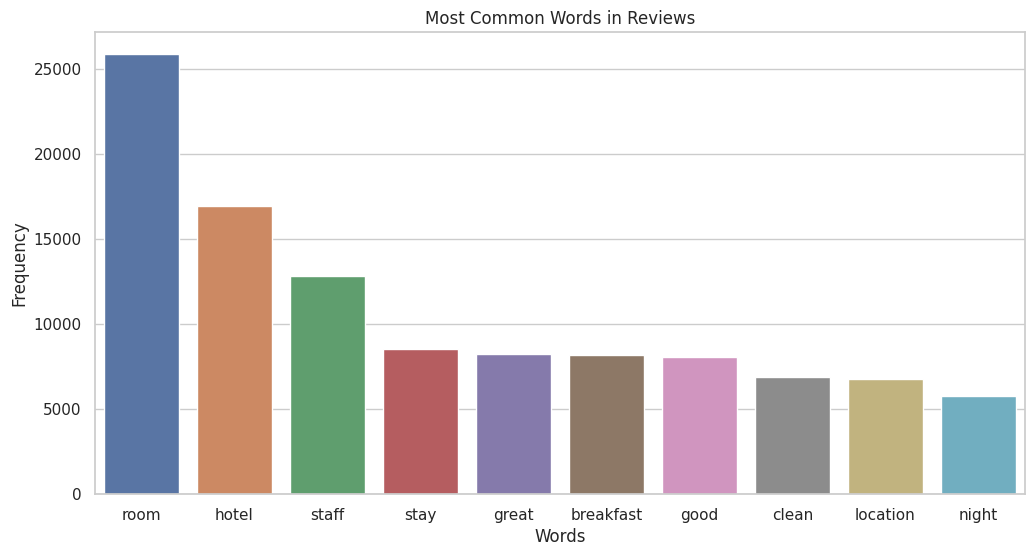

In [ ]:
# Finding and displaying the most common words
full_text = ' '.join(data['review_text_cleaned'])
list_words = full_text.split()
common_words = Counter(list_words).most_common(10)

# Plotting the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.savefig('plots/4.2a. Most common words in Review texts.png', bbox_inches='tight')
plt.show()

Plot a WordCloud of the most common words in the reviews.

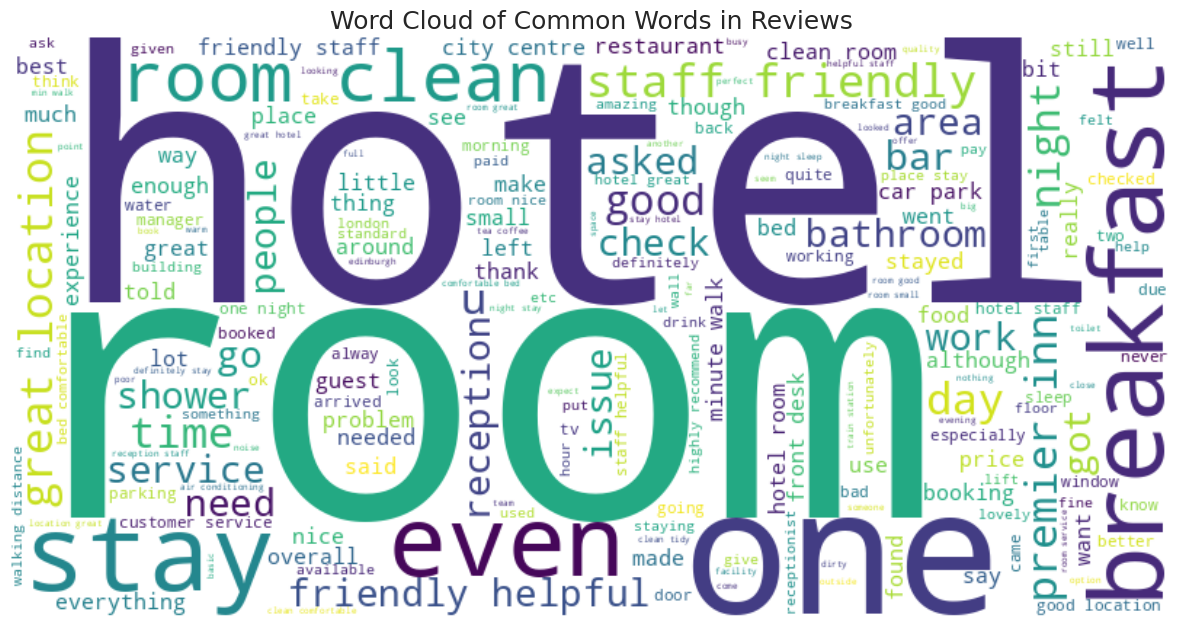

In [ ]:
# Creating a word cloud for the most frequent words in the reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)

# Displaying the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words in Reviews', fontsize=18)
plt.savefig('plots/4.2b. Word Cloud of Common Words in Reviews Texts.png', bbox_inches='tight')
plt.show()

### 4.3. Sentiment Analysis

**Lexicon-based approach**

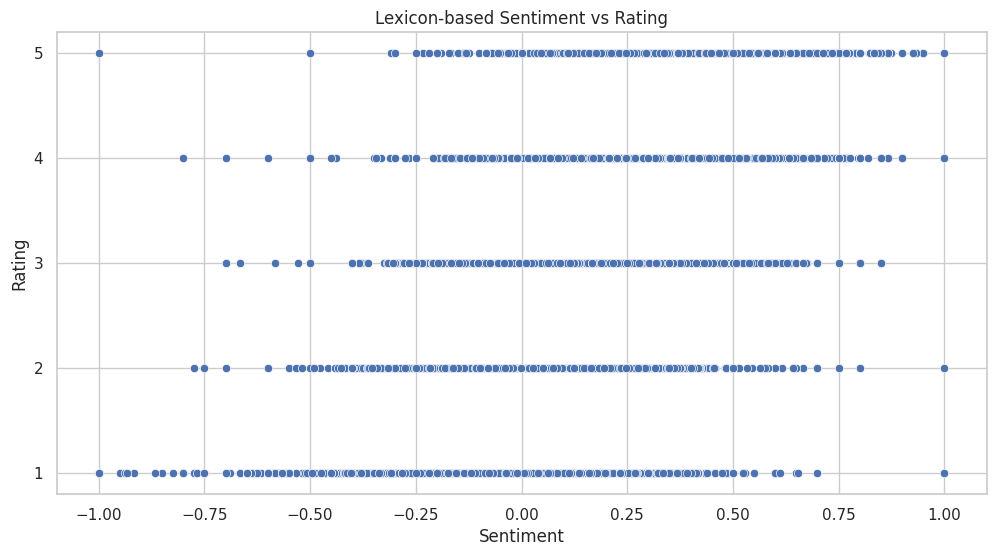

In [ ]:
# Sentiment Analysis on Review Text
# Adding a new column 'sentiment' to the data, representing the polarity of the review text
data['sentiment_lexicon_based'] = data['review_text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the relationship between Sentiment and Ratings
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment_lexicon_based', y='rating', data=data)
plt.yticks(range(1, 6))
plt.title('Lexicon-based Sentiment vs Rating')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.savefig('plots/4.3a. Lexicon-based Sentiment vs Rating.png', bbox_inches='tight')
plt.show()

**Deep learning-based approach**

In [ ]:
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    padding='max_length',
    truncation=True,
    max_length=512,
    device=0,
    batch_size=64
)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Analyse sentiment of both `review text` and `cleaned review text` and classify them into on of 3 categories: ['positive', 'neural', 'negative']

In [ ]:
raw_reviews = list(data['review_text'])
data['sentiment_transformer_based_raw'] = pd.DataFrame(distilled_student_sentiment_classifier(raw_reviews))['label']
data['sentiment_transformer_based_raw'].value_counts()

positive    14811
negative     5183
neutral       480
Name: sentiment_transformer_based_raw, dtype: int64

In [ ]:
cleaned_reviews = list(data['review_text_cleaned'])
data['sentiment_transformer_based'] = pd.DataFrame(distilled_student_sentiment_classifier(cleaned_reviews))['label']
data['sentiment_transformer_based'].value_counts()

positive    16652
negative     3778
neutral        44
Name: sentiment_transformer_based, dtype: int64

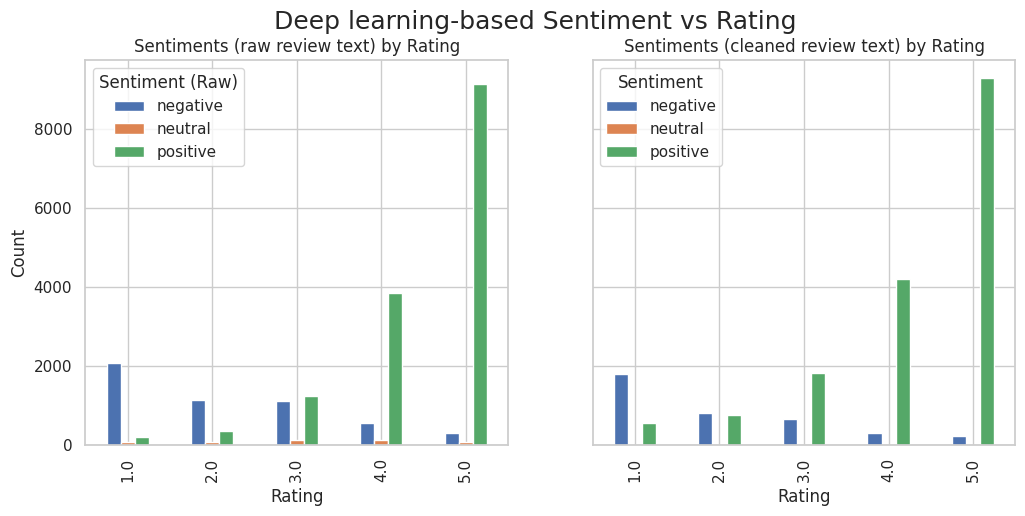

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.suptitle('Deep learning-based Sentiment vs Rating', fontsize=18)

# Figure 1: Raw text
counts1 = data.groupby(['rating', 'sentiment_transformer_based_raw']).size().unstack(fill_value=0)
counts1.plot(kind='bar', stacked=False, ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Sentiments (raw review text) by Rating')
axes[0].legend(title='Sentiment (Raw)')

# Figure 2: Cleaned text
counts2 = data.groupby(['rating', 'sentiment_transformer_based']).size().unstack(fill_value=0)
counts2.plot(kind='bar', stacked=False, ax=axes[1])
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].set_title('Sentiments (cleaned review text) by Rating')
axes[1].legend(title='Sentiment')

plt.savefig('plots/4.3b. Deep learning-based Sentiment vs Rating.png', bbox_inches='tight')
plt.show()


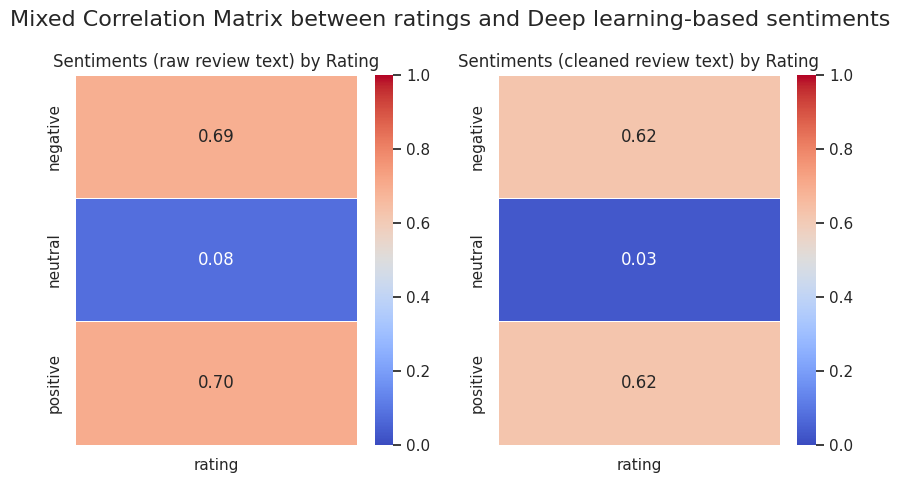

In [ ]:
# One-hot encode sentiment
sentiment_raw_dummies = pd.get_dummies(data['sentiment_transformer_based_raw'])
sentiment_cleaned_dummies = pd.get_dummies(data['sentiment_transformer_based'])
ratings = data.loc[:, ['rating']]

correlation_matrix_raw = compute_cat_corr(sentiment_raw_dummies, ratings, corr_type='mixed')
correlation_matrix_cleaned = compute_cat_corr(sentiment_cleaned_dummies, ratings, corr_type='mixed')

# plot heatmap
plt.figure(figsize=(10, 5))
plt.suptitle("Mixed Correlation Matrix between ratings and Deep learning-based sentiments", fontsize=16)
plt.subplots_adjust(top=0.85)

plt.subplot(1,2,1)
plt.title('Sentiments (raw review text) by Rating')
sns.heatmap(correlation_matrix_raw, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.title('Sentiments (cleaned review text) by Rating')
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=0, vmax=1)

plt.savefig('plots/4.3c. Deep learning-based Sentiment vs Rating (Correlation).png', bbox_inches='tight')
plt.show()


# Machine Learning Sentiment Classification

## Define train and test set

In [ ]:
# Use cleaned review text as input and sentiment classified by DL model as target
x = data.loc[:, 'review_text_cleaned'].values
y = data.loc[:, 'sentiment_transformer_based_raw'].values

In [ ]:
# Split dataset into train set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    random_state = 0)

##Deploying NB model with BoW

Vectorize reviews data with `CountVectorizer`

In [ ]:
# Learn representation from whole data
count_vect = CountVectorizer().fit(x)

#Fitting and transforming input data
bow_train = count_vect.transform(X_train).toarray()
bow_test = count_vect.transform(X_test).toarray()

Train Naive Bayes model

In [ ]:
# instantiate the model
NB = GaussianNB()

# fit the model with data
NB.fit(bow_train, y_train)

GaussianNB()

Evaluate model

In [ ]:
predicted_NB = NB.predict(bow_test)
print(classification_report(y_test, predicted_NB))

              precision    recall  f1-score   support

    negative       0.31      0.78      0.45      1019
     neutral       0.03      0.14      0.04       110
    positive       0.81      0.27      0.40      2966

    accuracy                           0.39      4095
   macro avg       0.38      0.39      0.30      4095
weighted avg       0.66      0.39      0.40      4095



##Deploying NB model with Tfidf

Vectorize reviews data with `TfidfVectorizer`

In [ ]:
# Learn representation from whole data
tfidf = TfidfVectorizer().fit(x)

#Fitting and transforming input data
tfidf_train = tfidf.transform(X_train).toarray()
tfidf_test = tfidf.transform(X_test).toarray()

Train Naive Bayes model

In [ ]:
# instantiate the model
NB = GaussianNB()

# fit the model with data
NB.fit(tfidf_train, y_train)

GaussianNB()

Evaluate model

In [ ]:
predicted_NB = NB.predict(tfidf_test)
print(classification_report(y_test, predicted_NB))

              precision    recall  f1-score   support

    negative       0.32      0.74      0.45      1019
     neutral       0.03      0.14      0.04       110
    positive       0.81      0.32      0.46      2966

    accuracy                           0.42      4095
   macro avg       0.39      0.40      0.32      4095
weighted avg       0.67      0.42      0.45      4095



# Download plots

In [ ]:
# Zip all plots into plots.zip file
!zip -r /content/plots.zip /content/plots/


updating: content/plots/ (stored 0%)
updating: content/plots/4.3b. Deep learning-based Sentiment vs Rating.png (deflated 14%)
updating: content/plots/4.3a. Lexicon-based Sentiment vs Rating.png (deflated 12%)
updating: content/plots/2.1. Trip Ratings by Companion Type.png (deflated 8%)
updating: content/plots/4.2b. Word Cloud of Common Words in Reviews Texts.png (deflated 0%)
updating: content/plots/4.2a. Most common words in Review texts.png (deflated 23%)
updating: content/plots/3.2. Mixed Correlation Matrix between categorical and continuous features.png (deflated 10%)
updating: content/plots/4.3c. Deep learning-based Sentiment vs Rating (Correlation).png (deflated 11%)
updating: content/plots/4.1a. Distribution of Review Text Length by Characters.png (deflated 18%)
updating: content/plots/3.1. Theil's U Correlation Matrix for Categorical fields.png (deflated 11%)
updating: content/plots/4.1b. Distribution of Review Text Length by Tokens.png (deflated 18%)
updating: content/plots/2.